# 【6】2008.1-2021.9年的来澳旅客陆路人次（90%数据建模）

## 0.1-导入包

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.tsa.api as smt
import statsmodels.tsa.arima.model as smt2
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test

## 0.2-绘制时序图、ACF、PACF图（statsmodels自带的函数）

In [18]:
def drawts(y,pname,Type,notes,mylag=36):
    ##draw ax
    fig = plt.figure(figsize=(15,12))
    ts_ax=plt.subplot2grid((2,2),(0,0),colspan=2)
    acf_ax=plt.subplot2grid((2,2),(1,0))
    pacf_ax=plt.subplot2grid((2,2),(1,1))
    ##draw plot
    ts_ax.plot(y,'*-')
    smt.graphics.plot_acf(y,lags=mylag,ax=acf_ax,alpha=0.05) ##2sigma
    smt.graphics.plot_pacf(y,lags=mylag,ax=pacf_ax,alpha=0.05)  ##2sigma
    #plt.savefig('%s.jpg'%pname,dpi=256)
    
    # plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['font.size'] = '15'
    plt.rcParams['axes.unicode_minus'] = False
    
    fig.suptitle("Time Series Analysis Plots of %s by %s(90%% data)"%(notes,Type),fontsize = 20)
    ts_ax.set_title('Sequence Chart')
    ts_ax.set_xlabel("Time(months)")
    ts_ax.set_ylabel("Number of %s passengers(person)"%Type)
    acf_ax.set_xlabel("number of lags(period)")
    acf_ax.set_ylabel("correlation")
    pacf_ax.set_xlabel("number of lags(period)")
    pacf_ax.set_ylabel("correlation")
    plt.savefig("Time Series Analysis Plots of %s(90%% data) by %s.jpg"%(notes,Type),dpi=256)
    plt.show()
    plt.close()

## 0.3-LB统计量（statsmodels自带的LB test函数）

In [19]:
def purerandtest(y,mylag=24):
    a,b=lb_test(y,lags=mylag,boxpierce=False)
    LB_purerand=pd.DataFrame(np.c_[a,b],columns=['LB','Pvalue'])
    LB_purerand['lags']=range(1,len(a)+1)
    print('----time series: LB pure randomness test----')
    print(LB_purerand)

## 0.4-绘图（真实值+拟合值+预测值）

In [20]:
def plot_all(y,mypred,Type,mylen):
    plt.figure(figsize=(24,12))         # 设置画布大小
    plt.plot(y,'-',label='observe')                                # 真实值
    startdraw=20
    plt.plot(np.arange(startdraw,mypred.predicted_mean.shape[0]),mypred.predicted_mean[startdraw:],'-*',label='fit')
    plt.plot(np.arange(mylen,mypred.predicted_mean.shape[0]),mypred.predicted_mean[mylen:],'-*',label='predict')

    plt.fill_between(np.arange(startdraw,mypred.predicted_mean.shape[0]),
                 mypred.conf_int(0.05)[startdraw:,0],
                 mypred.conf_int(0.05)[startdraw:,1],
                 color='lightblue')                    # 绘制置信区间
    plt.rcParams['font.size'] = '15'
    plt.legend()                                          # 添加图例
    plt.xlabel("Time(months)")                            # xlabel 
    plt.ylabel("Number of %s passengers(person)"%Type)    # ylabel
    plt.title('%s(90%% data)\'s fitted and predictive value'%Type)   # 添加标题
    plt.savefig('%s(90%% data)\'s fitted and predictive value.jpg'%Type,dpi=256)
    plt.show()                                    # 显示图像
    plt.close()                                   # 关闭图像

## 0.5-模型比较定阶

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook
from statsmodels.tsa.arima_model import ARIMA
import warnings
# 忽视在模型拟合中遇到的错误
warnings.filterwarnings("ignore")
# 找最优的参数 SARIMAX
def find_best_params(data:np.array, params_list,m):
    result = []
    best_bic = 100000
    for param in tqdm_notebook(params_list):
        # 模型拟合
        # model = SARIMAX(data,order=(param[0], param[1], param[2]),seasonal_order=(param[3], param[4], param[5], 12)).fit(disp=-1)
        model = SARIMAX(data, order=(param[0], param[1], param[2]), seasonal_order=(param[3], param[4], param[5], 12)).fit(disp=-1)
        bicc = model.bic # 拟合出模型的BIC值
        # print(bic)
        # 寻找最优的参数
        if bicc < best_bic:
            best_mode = model
            best_bic = bicc
            best_param = param
        param_1 = (param[0], param[1], param[2])
        param_2 = (param[3], param[4], param[5], m)
        param = 'SARIMA{0}x{1}'.format(param_1, param_2)
        print(param)
        result.append([param,model.aic, model.bic])

    result_table = pd.DataFrame(result)
    result_table.columns = ['parameters','AIC', 'BIC']
    result_table = result_table.sort_values(by='BIC',ascending=True).reset_index(drop=True)
    return result_table

## 1-时序图

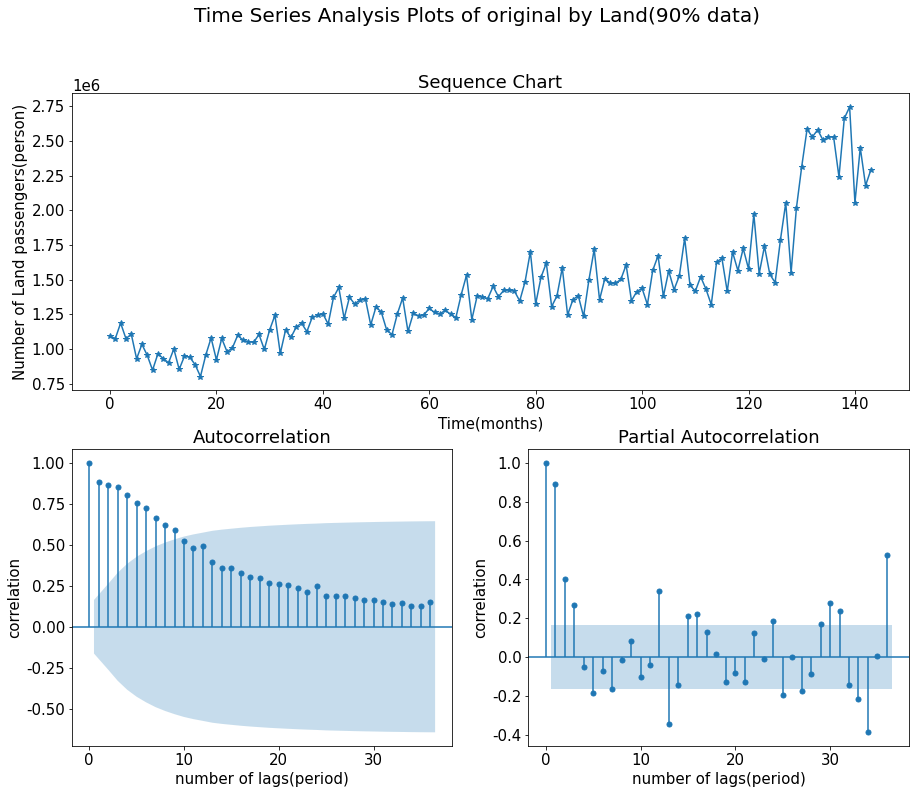

In [22]:
## read data
dfname='按入境渠道统计之来澳旅客陆路人次'
Type = 'Land'
y=pd.read_excel('%s.xlsx'%dfname,header=None)
y.iloc[:,1]=y.iloc[:,1]
y=y.values[:,1].astype('float')

## Take 90% of the data
# mylen=int(len(y)*0.9)
mylen = 144             # 2008.1--2019.12疫情前的数据
party=y[0:mylen]

## plot figure
notes = 'original'      # 原始序列
drawts(party,dfname,Type,notes)

## 2-差分运算：使序列平稳化
### 2.1-判断是否是异方差

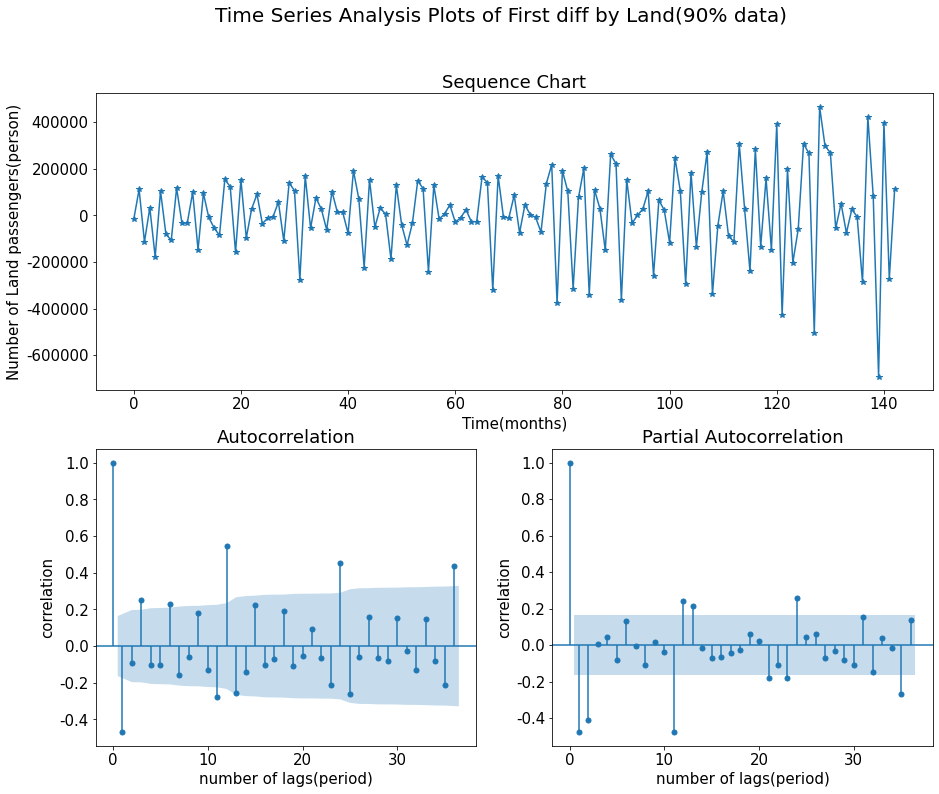

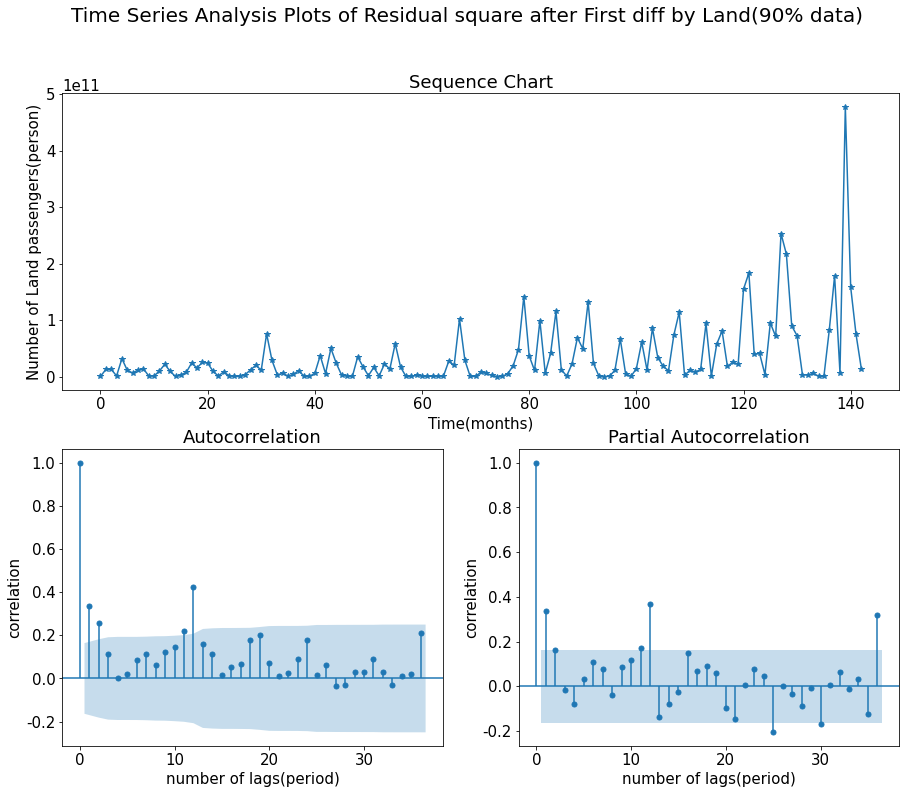

In [23]:
## 一阶差分
yd=party[1:]-party[:-1]
notes = 'First diff'    # 一阶差分
drawts(yd,dfname,Type,notes)

## 一阶差分后的残差平方图
notes = 'Residual square after First diff'    # 一阶差分后的残差平方图
drawts(yd**2,dfname,Type,notes)

### 2.2-方差齐性变换
$$  y_t=log(x_t)  $$

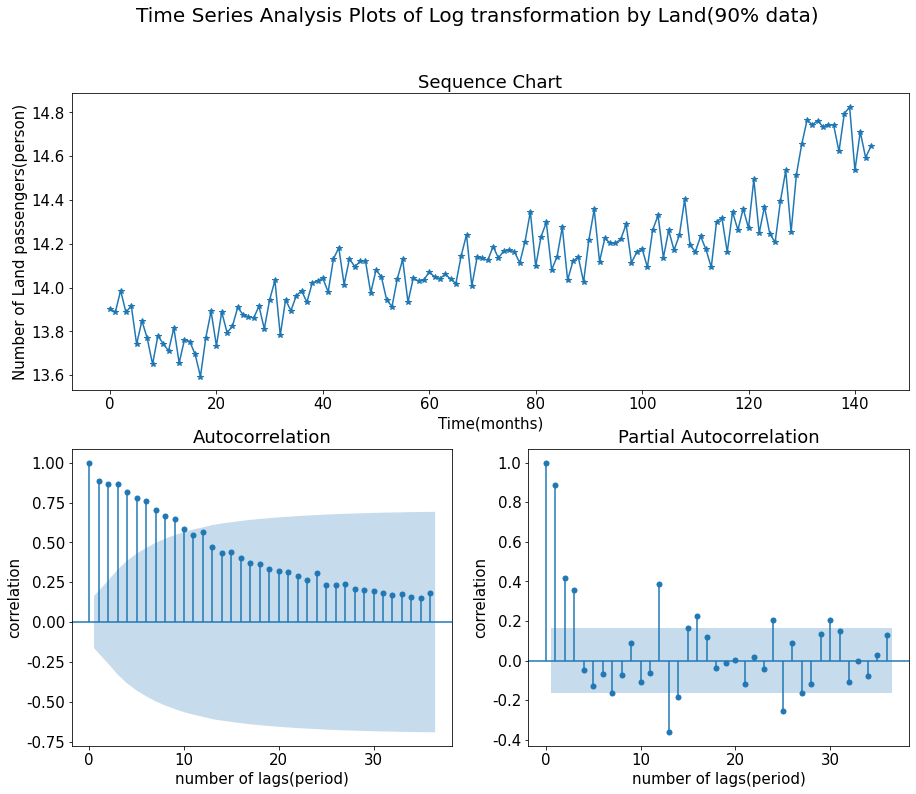

In [24]:
## 对数变换
newy=np.log(party)
notes = 'Log transformation'   # 对数变换后
drawts(newy,dfname,Type,notes)

### 2.3-对数变换后一阶12步差分

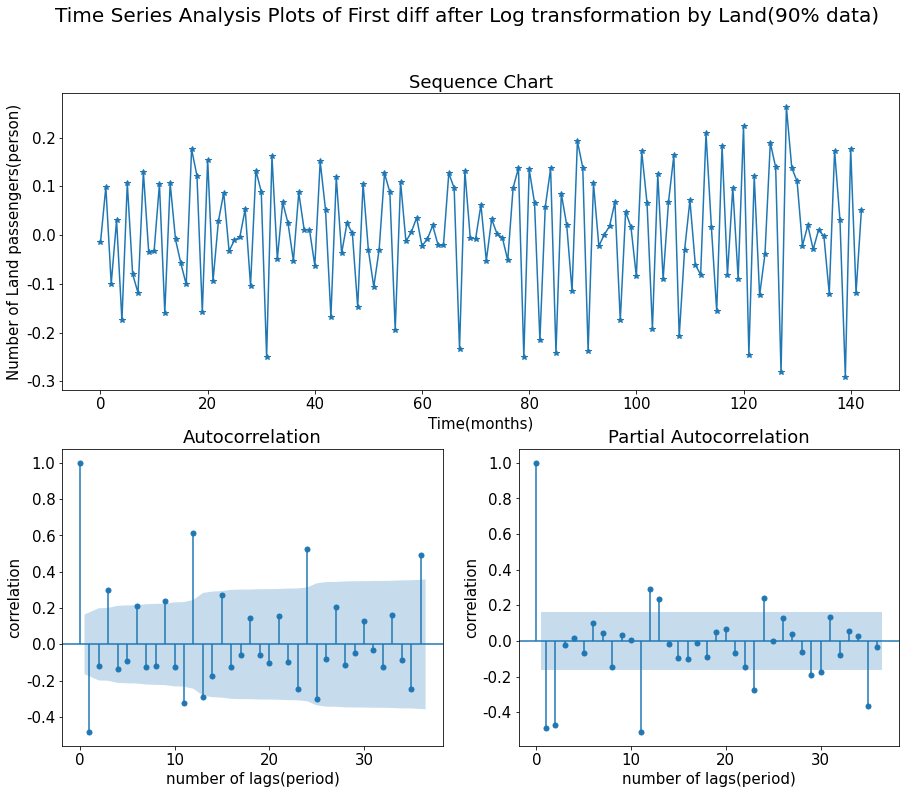

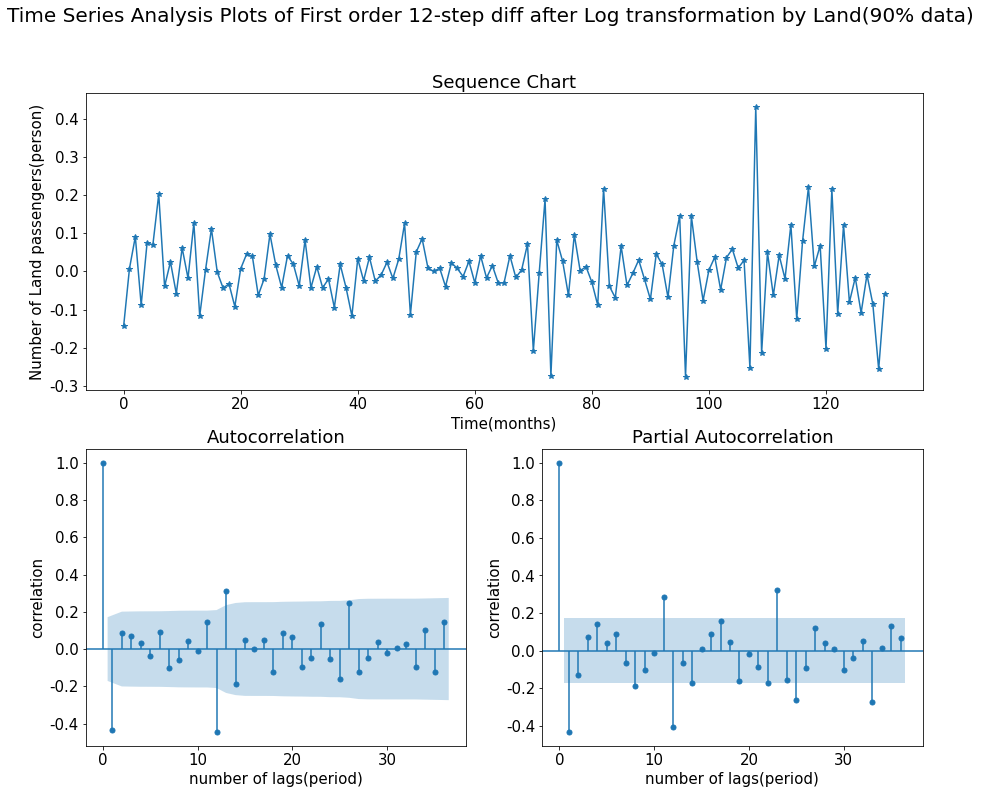

In [25]:
## 一阶差分
yd=newy[1:]-newy[:-1]
notes = 'First diff after Log transformation'   # 对数变换后一阶差分
drawts(yd,dfname,Type,notes)

## 12步差分
yd=yd[12:]-yd[:-12]
notes = 'First order 12-step diff after Log transformation'   # 对数变换后一阶12步差分
drawts(yd,dfname,Type,notes)

## 3-白噪声检验

In [26]:
purerandtest(yd)

----time series: LB pure randomness test----
           LB        Pvalue  lags
0   25.032168  5.638178e-07     1
1   26.000092  2.260225e-06     2
2   26.692562  6.829048e-06     3
3   26.851657  2.129990e-05     4
4   27.060415  5.551776e-05     5
5   28.185095  8.671254e-05     6
6   29.642472  1.104207e-04     7
7   30.090463  2.037347e-04     8
8   30.326396  3.859917e-04     9
9   30.349171  7.509103e-04    10
10  33.454580  4.439226e-04    11
11  62.712054  7.198565e-09    12
12  76.887829  4.230084e-11    13
13  82.178505  1.113708e-11    14
14  82.519599  2.410755e-11    15
15  82.519905  5.829391e-11    16
16  82.848032  1.191464e-10    17
17  85.090167  1.086240e-10    18
18  86.300435  1.490222e-10    19
19  87.000970  2.467593e-10    20
20  88.429575  3.007338e-10    21
21  88.818206  5.441487e-10    22
22  91.693072  3.688561e-10    23
23  92.162235  6.304688e-10    24


- 差分后LB统计量对应的6、12期的P值<0.05，是非白噪声序列

## 4-建模，参数估计

### 4.1-模型定阶

In [27]:
from itertools import product
# ARIMA的参数
ps = range(1, 5)
d = range(1, 2)
qs = range(1, 5)
# 季节项相关的参数
Ps = range(0, 2)
D = range(1, 2)
Qs = range(0, 2)
m = 12
# 将参数打包，传入下面的数据，是哦那个BIC准则进行参数选择
params_list = list(product(ps, d, qs, Ps, D, Qs))

result_table = find_best_params(newy, params_list,m)
print(result_table)

SARIMA(1, 1, 1)x(0, 1, 0, 12)
SARIMA(1, 1, 1)x(0, 1, 1, 12)
SARIMA(1, 1, 1)x(1, 1, 0, 12)
SARIMA(1, 1, 1)x(1, 1, 1, 12)
SARIMA(1, 1, 2)x(0, 1, 0, 12)
SARIMA(1, 1, 2)x(0, 1, 1, 12)
SARIMA(1, 1, 2)x(1, 1, 0, 12)
SARIMA(1, 1, 2)x(1, 1, 1, 12)
SARIMA(1, 1, 3)x(0, 1, 0, 12)
SARIMA(1, 1, 3)x(0, 1, 1, 12)
SARIMA(1, 1, 3)x(1, 1, 0, 12)
SARIMA(1, 1, 3)x(1, 1, 1, 12)
SARIMA(1, 1, 4)x(0, 1, 0, 12)
SARIMA(1, 1, 4)x(0, 1, 1, 12)
SARIMA(1, 1, 4)x(1, 1, 0, 12)
SARIMA(1, 1, 4)x(1, 1, 1, 12)
SARIMA(2, 1, 1)x(0, 1, 0, 12)
SARIMA(2, 1, 1)x(0, 1, 1, 12)
SARIMA(2, 1, 1)x(1, 1, 0, 12)
SARIMA(2, 1, 1)x(1, 1, 1, 12)
SARIMA(2, 1, 2)x(0, 1, 0, 12)
SARIMA(2, 1, 2)x(0, 1, 1, 12)
SARIMA(2, 1, 2)x(1, 1, 0, 12)
SARIMA(2, 1, 2)x(1, 1, 1, 12)
SARIMA(2, 1, 3)x(0, 1, 0, 12)
SARIMA(2, 1, 3)x(0, 1, 1, 12)
SARIMA(2, 1, 3)x(1, 1, 0, 12)
SARIMA(2, 1, 3)x(1, 1, 1, 12)
SARIMA(2, 1, 4)x(0, 1, 0, 12)
SARIMA(2, 1, 4)x(0, 1, 1, 12)
SARIMA(2, 1, 4)x(1, 1, 0, 12)
SARIMA(2, 1, 4)x(1, 1, 1, 12)
SARIMA(3, 1, 1)x(0, 1, 0, 12)
SARIMA(3, 

### 4.2-使用$SARIMA(p,d,q)(P,D,Q)_m$建模
$$
(1-\phi_1B-...-\phi_pB^p)(1-\Phi_1B-...-\Phi_pB^{Pm})(1-B^m)^D(1-B)^dx_t=(1-\theta_1B-...-\theta_qB^q)(1-\Theta_1B-...-\Theta_QB^{Qm})\varepsilon_t
$$

In [29]:
## SARIMA 
arma10=smt2.ARIMA(newy,order=(1,1,2),seasonal_order=(0,1,1,12),trend='n').fit() #trend=n,c,t,ct
print('----fitting summary----')
print(arma10.summary())

----fitting summary----
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             ARIMA(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 161.607
Date:                            Fri, 03 Dec 2021   AIC                           -313.214
Time:                                    12:33:20   BIC                           -298.838
Sample:                                         0   HQIC                          -307.372
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4251      0.311      1.368      0.171      -0.184       1.034
ma.L1      

## 5-模型显著性检验（残差检验）

In [30]:
resid=arma10.resid
print('\n----residual pure randomness test')
purerandtest(resid)


----residual pure randomness test
----time series: LB pure randomness test----
           LB    Pvalue  lags
0    0.004386  0.947198     1
1    0.018404  0.990840     2
2    0.034103  0.998342     3
3    0.041396  0.999789     4
4    0.051355  0.999969     5
5    0.051723  0.999997     6
6    0.057081  1.000000     7
7    0.068463  1.000000     8
8    0.090532  1.000000     9
9    0.090537  1.000000    10
10   0.090597  1.000000    11
11  24.995914  0.014842    12
12  25.015252  0.022977    13
13  25.016036  0.034409    14
14  25.019367  0.049684    15
15  25.021984  0.069439    16
16  25.022029  0.094218    17
17  25.026031  0.124201    18
18  25.053150  0.158800    19
19  25.060190  0.199138    20
20  25.060201  0.244566    21
21  25.068308  0.293819    22
22  25.071629  0.346603    23
23  25.071772  0.401869    24


- 残差序列在6、12期的LB统计量对应的P值>0.05，显著，残差序列为白噪声序列，即拟合模型显著有效

## 6-拟合+7-预测

In [31]:
myalpha=0.05
mypred=arma10.get_prediction(start=1,end=len(y),dynamic=False)  ##if True, start >0

## 
mypred.predicted_mean[:]=np.exp(mypred.predicted_mean[:])
mypred.conf_int(0.05)[:,:]=np.exp(mypred.conf_int(0.05)[:,:])

## fitted
print('\n----fitted confidence interval: %d %%'%((1-myalpha)*100))
print(mypred.summary_frame(alpha=myalpha))


----fitted confidence interval: 95 %
y            mean      mean_se  mean_ci_lower  mean_ci_upper
0    1.091513e+06  1000.000005   1.089553e+06   1.093473e+06
1    1.075059e+06  1000.000005   1.073099e+06   1.077019e+06
2    1.186777e+06  1000.000005   1.184817e+06   1.188737e+06
3    1.074022e+06  1000.000005   1.072062e+06   1.075982e+06
4    1.106857e+06  1000.000005   1.104897e+06   1.108817e+06
..            ...          ...            ...            ...
160  2.062879e+06     0.261535   2.062878e+06   2.062879e+06
161  2.451264e+06     0.271714   2.451263e+06   2.451264e+06
162  2.639840e+06     0.281540   2.639840e+06   2.639841e+06
163  2.079882e+06     0.291041   2.079882e+06   2.079883e+06
164  2.476167e+06     0.300245   2.476166e+06   2.476167e+06

[165 rows x 4 columns]


## 8-绘图

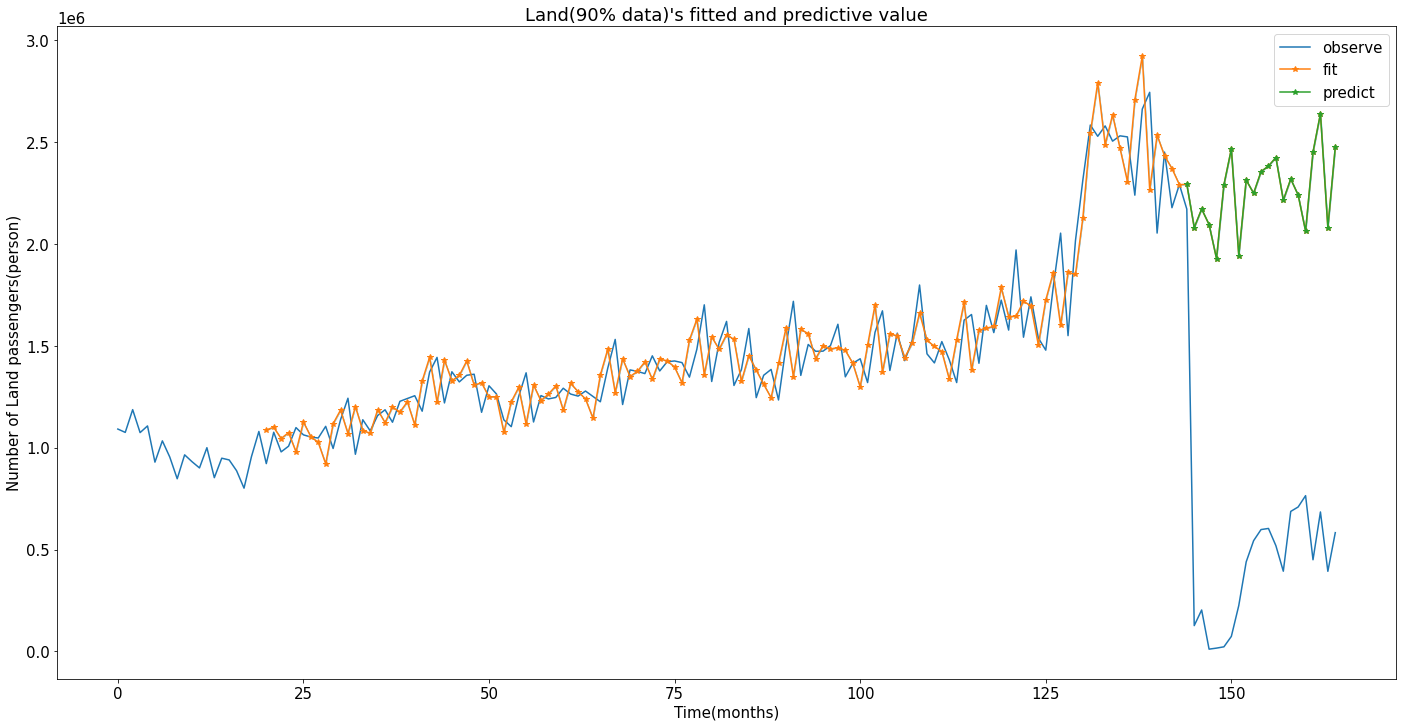

In [32]:
plot_all(y,mypred,Type,mylen)

## 9-评价疫情恢复情况

> 146期（对应index=145）为疫情发生月、判断147~165期的疫情恢复情况

- 第0期的真实值（疫情发生月）：$A_0$
- 第0期的估计值（疫情发生月）：$P_0$
- 第i期的真实值（有疫情）：$A_i$
- 第i期的估计值（无疫情）：$P_i$
- 第i期的旅客人数恢复率：${RE}_i$
$${RE}_i = 1 - \cfrac{\cfrac{(P_i-A_i)}{P_i}}{\cfrac{(P_0-A_0)}{P_0}},i=147,148,...165$$

In [33]:
REi = []
for i in range(mylen+2,len(y)):
    REi.append(1 - ((mypred.predicted_mean[i]-y[i])/mypred.predicted_mean[i])/((mypred.predicted_mean[145]-y[145])/mypred.predicted_mean[145])) 

print(REi)
pd.DataFrame(REi[:]).to_excel('../REi_plot/LandREi.xlsx')   # 存储拟合值

[0.034909521447028524, -0.05916551776952339, -0.05587591526375335, -0.05431352093746855, -0.03297408125215462, 0.05851402845534803, 0.1374921199617456, 0.19255502612787823, 0.20560488057774884, 0.2049436697387912, 0.16315305179352957, 0.12447165514401315, 0.25075243490783516, 0.2721912149517177, 0.3298720829147559, 0.13062204474849892, 0.21131268745692977, 0.13647017758495095, 0.18590408414650728]
